# Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

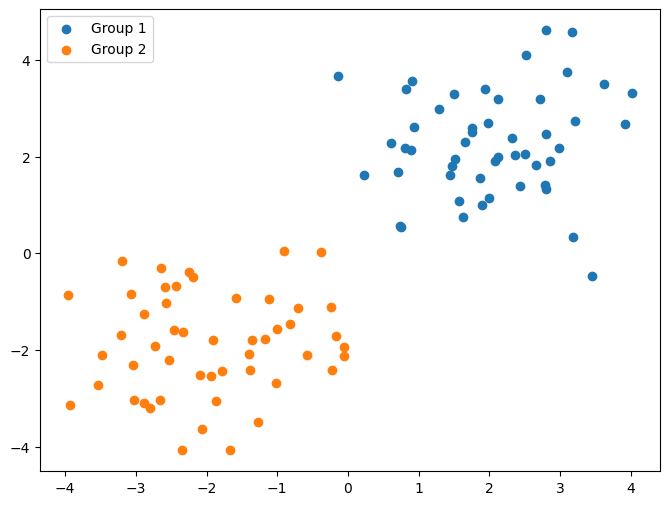

In [38]:
X = np.concatenate([
    np.array([
        np.random.normal(size=50, loc=2),
        np.random.normal(size=50, loc=2)
    ]).T,
    np.array([
        np.random.normal(size=50, loc=-2),
        np.random.normal(size=50, loc=-2)
    ]).T
])

y = np.concatenate([
    np.zeros(50),
    np.ones(50)
])

plt.figure(figsize=(8, 6))
plt.scatter(X[y==0].T[0], X[y==0].T[1], label="Group 1")
plt.scatter(X[y==1].T[0], X[y==1].T[1], label="Group 2")
plt.legend()
plt.show()

# Model

Sources:
- <a href="https://www.youtube.com/watch?v=LsK-xG1cLYA">StatQuest</a>
- <a href="https://www.youtube.com/watch?v=wF5t4Mmv5us">Patrick Loeber</a>

In [23]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]

        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions

In [49]:
class AdaBoost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []

        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")

            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

# Train

In [50]:
from sklearn.model_selection import train_test_split

y_ada = y.copy()
y_ada[y_ada==0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y_ada, test_size=0.2, random_state=42)

ada = AdaBoost()
ada.fit(X_train, y_train)

# Evaluate

In [51]:
from sklearn.metrics import accuracy_score

y_pred = ada.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100}%")

Accuracy: 95.0%
